In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Import the Data

In [2]:
app_train=pd.read_csv("C:\\Users\Debodeep\Documents\Sapienza Learning Materials\FDA\Project\Data\\application_train.csv")
app_test=pd.read_csv("C:\\Users\Debodeep\Documents\Sapienza Learning Materials\FDA\Project\Data\\application_test.csv")
bureau=pd.read_csv("C:\\Users\Debodeep\Documents\Sapienza Learning Materials\FDA\Project\Data\\bureau.csv")
samp_sub=pd.read_csv("C:\\Users\Debodeep\Documents\Sapienza Learning Materials\FDA\Project\Data\\sample_submission.csv")
prev_appl=pd.read_csv("C:\\Users\Debodeep\Documents\Sapienza Learning Materials\FDA\Project\Data\\previous_application.csv")

In [3]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [6]:
objective=app_train.TARGET

In [7]:
app_test.shape

(48744, 121)

In [8]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


#Exploratory Data Analysis:

In [9]:
# Examine the missing values.
# Please note, we will just check the information on the missing values. 
# We will not remove any column as of now because we don't know which column is going to be important in future.
# Function to detect missing values.
def missing_info(dataframe):
  count=dataframe.isnull().sum()
  # standardised score of the missing values:
  mean_null=sum(count)/len(dataframe.columns)
  var_null=sum(((count-mean_null)**2))/len(dataframe.columns)
  # Make a table with the results
  metric=((count-mean_null)/var_null)*1000000
  result=pd.concat([count,metric],axis=1)
  result.columns=["count","standardised_score"]
  result=result[result.iloc[:,1] != 0].sort_values(
          'count', ascending=False).round(1)
  return(result.head())


In [10]:
missing_info(app_train)

,count,standardised_score
COMMONAREA_MEDI,214865,18.4
COMMONAREA_AVG,214865,18.4
COMMONAREA_MODE,214865,18.4
NONLIVINGAPARTMENTS_MODE,213514,18.2
NONLIVINGAPARTMENTS_AVG,213514,18.2


In [11]:
missing_info(app_test)

,count,standardised_score
COMMONAREA_AVG,33495,120.9
COMMONAREA_MODE,33495,120.9
COMMONAREA_MEDI,33495,120.9
NONLIVINGAPARTMENTS_AVG,33347,120.1
NONLIVINGAPARTMENTS_MODE,33347,120.1


In [12]:
# As the prior focus is on the prediction of repaying the loan, the column under consideration is "TARGET".
# So, let's have a quick look at the distribution of the specific column.
# Here, 0 means that there was no problem in repaying the loan and 1 means that there was sum problem. Here we will look at the frequency of the 0 and 1
app_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [13]:
# From the above result we can see that 282686 customers didn't face any problem in repaying the loan whereas 24825 customers faced problem.

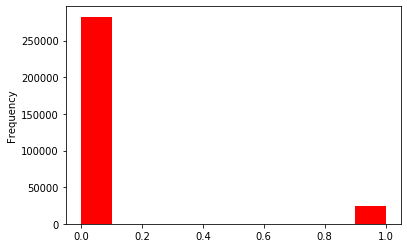

In [14]:
app_train['TARGET'].astype(int).plot.hist(color="red")

# Construct the prediction:

## Method 1: Logistic Regression

In [15]:
# The first hurdle we face is due to the columns with several categories. So, first we have to encode those columns to proceed further.
# Before that, let's have a look at the column types of the data sets.

#################### Function to check the column types #######################
def coltyp(dataframe):
  type=dataframe.dtypes.value_counts()
  #we will see number of unique categories for each object
  cat= dataframe.select_dtypes('object').apply(pd.Series.nunique,axis=0)
  print(type)
  return cat

In [16]:
coltyp(app_train)

float64    65
int64      41
object     16
dtype: int64


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [17]:
# Now we have to conduct the one hot encoding:

from sklearn.preprocessing import LabelEncoder as le

In [18]:
################### Function for one hot encoding #################
def onehot(dataframe):
  df=pd.get_dummies(dataframe)
  print(df.shape)
  return(df)


In [19]:
app_train=onehot(app_train)

(307511, 246)


In [20]:
app_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [21]:
app_test=onehot(app_test)

(48744, 242)


In [22]:
app_test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,0,1,0,1,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,0,0,1,0,0,1,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Imputing: As there are NaN values in several columns, we have to conduct an Imputing task

In [24]:
from sklearn.impute import SimpleImputer

In [25]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [26]:
imputer.fit(app_train)
app_train.loc[:]=imputer.transform(app_train)

In [27]:
imputer.fit(app_test)
app_test.loc[:]=imputer.transform(app_test)

In [28]:
# Aligning the Train and Test sets
train_set, test_set = app_train.align(app_test, join = 'inner', axis = 1)

In [29]:
#Logictic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(train_set,objective)

C:\Users\Debodeep\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
p=lr.predict_proba(test_set)[:,1]

In [31]:
output = app_test[['SK_ID_CURR']].astype(int)
output['TARGET'] = p

output.head()

,SK_ID_CURR,TARGET
0,100001,0.096987
1,100005,0.103224
2,100013,0.062623
3,100028,0.030703
4,100038,0.075685


In [32]:
output.to_csv('output.csv',index=False)

0.6194638071233214


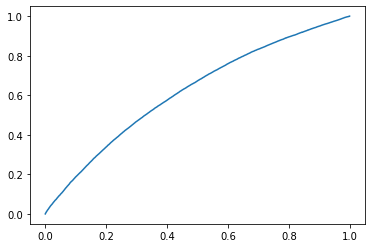

In [33]:
# Getting the ROC curve
p=lr.predict_proba(train_set)[:,1]
print(roc_auc_score(objective,p))
fpr,tpr,thr=roc_curve(objective,p)
plt.figure()
plt.plot(fpr,tpr)

In [34]:
app_train.shape

(307511, 246)

In [35]:
app_test.shape

(48744, 242)

# Rough: Feature Engineering

In [36]:
# Now we will compare the correlation of the other variables with the target features

In [37]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [38]:
prev_appl.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
prev_appl.shape

(1670214, 37)

In [61]:
features = pd.DataFrame()
# Employment to birth ratio
features['EmplBirth_ratio'] = train_set['DAYS_EMPLOYED'] /train_set['DAYS_BIRTH']
# Credit to annuity ratio
features['CA_ratio'] = train_set['AMT_CREDIT'] / train_set['AMT_ANNUITY']
# Credit- goods ratio
features['CrGood_ratio'] = train_set['AMT_CREDIT'] / train_set['AMT_GOODS_PRICE']
# Credit- Income ratio
features['CrInc_ratio'] = train_set['AMT_CREDIT'] /  train_set['AMT_INCOME_TOTAL']
# Income credit fraction
features['IncCr_frac'] = train_set['AMT_INCOME_TOTAL'] / train_set['AMT_CREDIT']
# Income per child
features['IncChild'] = train_set['AMT_INCOME_TOTAL'] / (1 + train_set['CNT_CHILDREN'])
# Income per person
features['Inc_Person'] = train_set['AMT_INCOME_TOTAL'] /train_set['CNT_FAM_MEMBERS']
# Payment rate
features['payment_rate'] = train_set['AMT_ANNUITY'] / train_set['AMT_CREDIT']
train_final = pd.concat([train_set, features], axis=1)

In [41]:
features = pd.DataFrame()
features['EmplBirth_ratio'] = test_set['DAYS_EMPLOYED'] /test_set['DAYS_BIRTH']

features['CA_ratio'] = test_set['AMT_CREDIT'] / test_set['AMT_ANNUITY']

features['CrGood_ratio'] = test_set['AMT_CREDIT'] / test_set['AMT_GOODS_PRICE']

features['CrInc_ratio'] = test_set['AMT_CREDIT'] /  test_set['AMT_INCOME_TOTAL']

features['IncCr_perc'] = test_set['AMT_INCOME_TOTAL'] / test_set['AMT_CREDIT']

features['IncChild'] = test_set['AMT_INCOME_TOTAL'] / (1 + test_set['CNT_CHILDREN'])

features['Inc_Person'] = test_set['AMT_INCOME_TOTAL'] /test_set['CNT_FAM_MEMBERS']

features['payment_rate'] = test_set['AMT_ANNUITY'] / test_set['AMT_CREDIT']

test_final = pd.concat([test_set, features], axis=1)

In [72]:
# We will merge the bureau data with the train_final and test_final datasets.
train_final=train_final.merge(bureau[['SK_ID_CURR','CREDIT_ACTIVE','CREDIT_CURRENCY']],on='SK_ID_CURR')

MemoryError: Unable to allocate 24.6 GiB for an array with shape (250, 13199003) and data type float64

In [ ]:
train_final.shape

In [43]:
test_final=test_final.merge(bureau[['SK_ID_CURR','CREDIT_ACTIVE','CREDIT_CURRENCY']],on='SK_ID_CURR')

In [44]:
train_final=onehot(train_final)

(1465325, 258)


In [45]:
test_final=onehot(test_final)

(251103, 258)


In [62]:
train_final.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EmplBirth_ratio,CA_ratio,CrGood_ratio,CrInc_ratio,IncCr_frac,IncChild,Inc_Person,payment_rate
0,100002.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,...,1.0,0.0,0.067329,16.461104,1.158397,2.007889,0.498036,202500.0,202500.0,0.060749
1,100003.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,...,1.0,0.0,0.070862,36.234085,1.145199,4.790750,0.208736,270000.0,135000.0,0.027598
2,100004.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,...,0.0,0.0,0.011814,20.000000,1.000000,2.000000,0.500000,67500.0,67500.0,0.050000
3,100006.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,...,0.0,0.0,0.159905,10.532818,1.052803,2.316167,0.431748,135000.0,67500.0,0.094941
4,100007.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,...,0.0,0.0,0.152418,23.461618,1.000000,4.222222,0.236842,121500.0,121500.0,0.042623


In [49]:
test_final.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,Inc_Person,payment_rate,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4
0,100001.0,0.0,135000.0,568800.0,20560.5,450000.0,0.01885,-19241.0,-2329.0,-5170.0,...,67500.0,0.036147,0,0,1,0,1,0,0,0
1,100001.0,0.0,135000.0,568800.0,20560.5,450000.0,0.01885,-19241.0,-2329.0,-5170.0,...,67500.0,0.036147,0,0,1,0,1,0,0,0
2,100001.0,0.0,135000.0,568800.0,20560.5,450000.0,0.01885,-19241.0,-2329.0,-5170.0,...,67500.0,0.036147,0,0,1,0,1,0,0,0
3,100001.0,0.0,135000.0,568800.0,20560.5,450000.0,0.01885,-19241.0,-2329.0,-5170.0,...,67500.0,0.036147,0,0,1,0,1,0,0,0
4,100001.0,0.0,135000.0,568800.0,20560.5,450000.0,0.01885,-19241.0,-2329.0,-5170.0,...,67500.0,0.036147,1,0,0,0,1,0,0,0


In [51]:
missing_info(train_final)

,count,standardised_score
SK_ID_CURR,0,NaN
ORGANIZATION_TYPE_Industry: type 8,0,NaN
WEEKDAY_APPR_PROCESS_START_SATURDAY,0,NaN
WEEKDAY_APPR_PROCESS_START_SUNDAY,0,NaN
WEEKDAY_APPR_PROCESS_START_THURSDAY,0,NaN


In [65]:
bureau.shape

(1716428, 17)

# Method 2: Boosting

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
boosting = GradientBoostingClassifier(random_state=0)
boosting.fit(train_final, app_train["TARGET"])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
len(train_final)

307511

In [113]:
p=boosting.predict_proba(test_set)[:,1]

In [114]:
output = app_test[['SK_ID_CURR']].astype(int)
output['TARGET'] = p

output.head()

,SK_ID_CURR,TARGET
0,100001,0.054751
1,100005,0.127813
2,100013,0.026152
3,100028,0.042211
4,100038,0.115596


0.7587852652784486


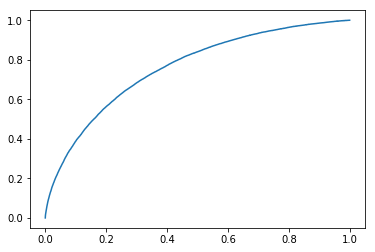

In [115]:
# Getting the ROC curve
p=boosting.predict_proba(train_set)[:,1]
print(roc_auc_score(objective,p))
fpr,tpr,thr=roc_curve(objective,p)
plt.figure()
plt.plot(fpr,tpr)

In [116]:
output.to_csv('output_boosting_feat_ex.csv',index=False)

### Application of Extreme gradient boosting:

In [47]:
# Here we will try to apply extreme gradient boosting:


In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [47]:
boosting_xgb = XGBClassifier(random_state=0)
boosting_xgb.fit(train_final, objective)

XGBoostError: [11:50:27] C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:60: Check failed: preds.Size() == info.labels_.Size() (1465325 vs. 307511) : labels are not correctly providedpreds.size=1465325, label.size=307511

In [ ]:
p=boosting_xgb.predict_proba(test_final)[:,1]

In [ ]:
output_xgb = app_test[['SK_ID_CURR']].astype(int)
output_xgb['TARGET'] = p

output_xgb.head()

In [ ]:
# Getting the ROC curve
p=boosting_xgb.predict_proba(train_final)[:,1]
print(roc_auc_score(objective,p))
fpr,tpr,thr=roc_curve(objective,p)
plt.figure()
plt.plot(fpr,tpr)

In [122]:
output_xgb.to_csv('output_xgb.csv',index=False)